In [12]:
import numpy as np 
import math 
import os 
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from datetime import datetime
currentDir = os.getcwd()
periodDir = os.path.join(currentDir,'data_Period.txt')
satellitiesDir = os.path.join(currentDir,'data_Satellities.txt')
dateFormat = '%Y-%m-%d %H:%M:%S'
plt.style.use('bmh')
pxToRads = 0.2638*4.84813681*10**(-6)
AUtoKm = 6.6845871226706*10**(-9)
distanceJupyter = 5.489 #Au
G = 6.6743*10**(-11)

In [13]:
jupyterPeriod = [] #Period in seconds
def timeToSeconds(timeStr):
    hours, minutes, seconds = map(int, timeStr.split(':'))
    return hours * 3600 + minutes * 60 + seconds  #The proper multipliers

with open(periodDir, 'r') as file:
    lines = file.readlines()
    for line in lines[1::]: #Skip the first row
        firstSight, secondSight = line.strip().split()
        jupyterPeriod.append(timeToSeconds(secondSight)-timeToSeconds(firstSight))

In [14]:
jupyterPeriod = np.array(jupyterPeriod)
jupyterPeriod
meanPeriod,stdPeriod = np.mean(jupyterPeriod),np.std(jupyterPeriod)
print(f'The self period of Jupyter is : {meanPeriod} seconds with an error of {stdPeriod:.5} seconds')
jupyterPeriod

The self period of Jupyter is : 35757.25 seconds with an error of 155.46 seconds


array([35976, 35657, 35572, 35824])

In [15]:
loadedData = [[],[],[],[],[],[]]
def datetimeToSeconds(stringDate): #It returns the seconds since jan 1970. we just care about the differences
    return float(datetime.strptime(stringDate,dateFormat).timestamp()) #Datetime lib takes care of the time conversion

with open(satellitiesDir, 'r') as file:
    lines = file.readlines()[1::] #Skip the first row
    for line in lines:
        currentRow = line.strip('\n').split('\t') #Split it by tabs to get the different columns 
        #and remove the \n character
        date = datetimeToSeconds(currentRow[0])
        loadedData[0].append(date)
        for index,element in enumerate(currentRow[1::]):
            clearedElement = element.strip(')').strip("(").split(',') #So we go through each row,
            #and we get the individual elements
            values = []
            for value in clearedElement:
                try:
                    values.append(float(value)) #If they are proper floats, store them eithewise fill the valuesArr
                    #with none,none
                except Exception as e:
                    values.append(None)
            loadedData[index+1].append(values) #Put the values in the appropriate place, so they match the proper celestial object
names = ['Europa', 'Ganymede', 'Io', 'Calisto']     

In [16]:
#Now to clear the data, as we want the difference in dates, and the distance not pixels
data = []
timesRenorm = []
for index in range(len(loadedData[0])):
    timesRenorm.append(loadedData[0][index]-loadedData[0][0])
data.append(timesRenorm)

In [17]:
for satelliteIndex in range(2,6):
    distValues = []
    for pos,jupPos in zip(loadedData[satelliteIndex],loadedData[1]):
        if pos[0] == None:
            distValues.append(None)
            continue
        else:
            #Get sign
            sign = math.copysign(1,pos[0])
            x,y = (jupPos[0]-abs(pos[0])), (jupPos[1]-pos[1])
            distance = sign* math.sqrt(x**2 +y**2)
            distValues.append(distance)
    data.append(distValues)

In [18]:
dataDict = {'Europa': [], 'Ganymede': [], 'Io':[] ,'Calisto':[]}

for indexSat, currentSat in enumerate(data[1::]):
    timeArr, valueArr = [], []
    for time, dist in zip(data[0],currentSat):
        if dist == None:
            continue
        else:
            timeArr.append(time)
            valueArr.append(dist)
    dataDict[names[indexSat]].append(timeArr)
    dataDict[names[indexSat]].append(valueArr)

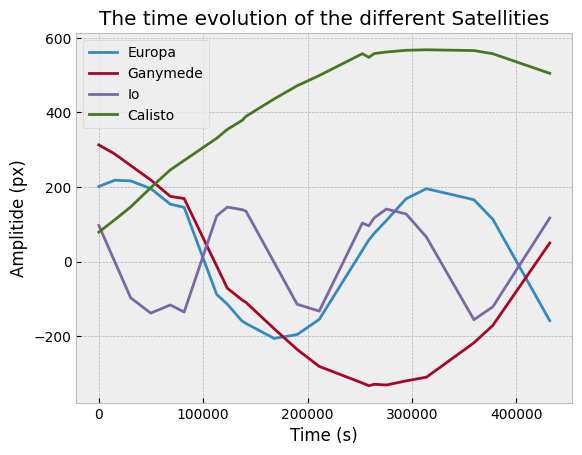

In [19]:
for sat in names:
    plt.plot(dataDict[sat][0],dataDict[sat][1],label=sat)
plt.title('The time evolution of the different Satellities')
plt.xlabel('Time (s)')
plt.ylabel('Amplitide (px)')
plt.legend()
plt.savefig('timeevolution.png')
plt.show()

In [20]:
def getHighestFrequency(time, values):
    time = np.array(time)
    values = np.array(values)
   
    fft_result = np.fft.fft(values)
    frequencies = np.fft.fftfreq(len(values), time[1] - time[0])
    magnitudes = np.abs(fft_result)
    peak_index = np.argmax(magnitudes)
    most_common_frequency = frequencies[peak_index]
    return most_common_frequency

In [21]:
params = []
physicalValues = {}
def fitFunc(x,a,b,c):
    return a*np.sin(b*x) + c*np.cos(b*x) #The resulting function is a sin with another amplitude and a phase factor, which we will ignore as it poses non physical significance
#Basically what we need to do is:
#1. Scale down the interval of the time series to something manageable
#2. Find the most common frequency by Fourier Analysis
#3. The maximum and smallest element in values to be the amplitude
#All this is needed because scipy eitherwise would not return a result that even resembles the data at all
#,as it is very sensitive to large values due to being based on the Least Squares Method 
for name in names:
    scaleFactor = (np.max(dataDict[name][0])-np.min(dataDict[name][0]))
    timeSeriesVar = np.array(dataDict[name][0])/scaleFactor
    valuesSeriesVar = dataDict[name][1]
    initialValues = [np.max(valuesSeriesVar),2*math.pi*getHighestFrequency(timeSeriesVar,valuesSeriesVar),np.min(valuesSeriesVar)]
    curveFittedParams = curve_fit(fitFunc,timeSeriesVar,valuesSeriesVar,p0=initialValues)
    params.append(curveFittedParams[0])
    #Now to deduce the physical constants we are after, the period and amplitude
    print(curveFittedParams[0])
    amplitude = math.sqrt((curveFittedParams[0][0])**2+(curveFittedParams[0][2])**2)
    period = 2*math.pi*scaleFactor/curveFittedParams[0][1]
    keplerRatio = amplitude**3/period**2
    #Now to find their error 
    perr = np.sqrt(np.diag(curveFittedParams[1]))
    errorPeriod = perr[1]
    errorRadius = np.sqrt((curveFittedParams[0][0]*perr[0]/amplitude)**2+(curveFittedParams[0][2]*perr[2]/amplitude)**2)
    physicalValues[name] = [amplitude,period,keplerRatio,errorRadius,errorPeriod]

[120.83740075   9.14326253 188.23710818]
[-131.32540917    4.42391186  316.49811588]
[-114.00355569   17.94557432  101.06324575]
[567.81100158   1.92026331  73.1830343 ]


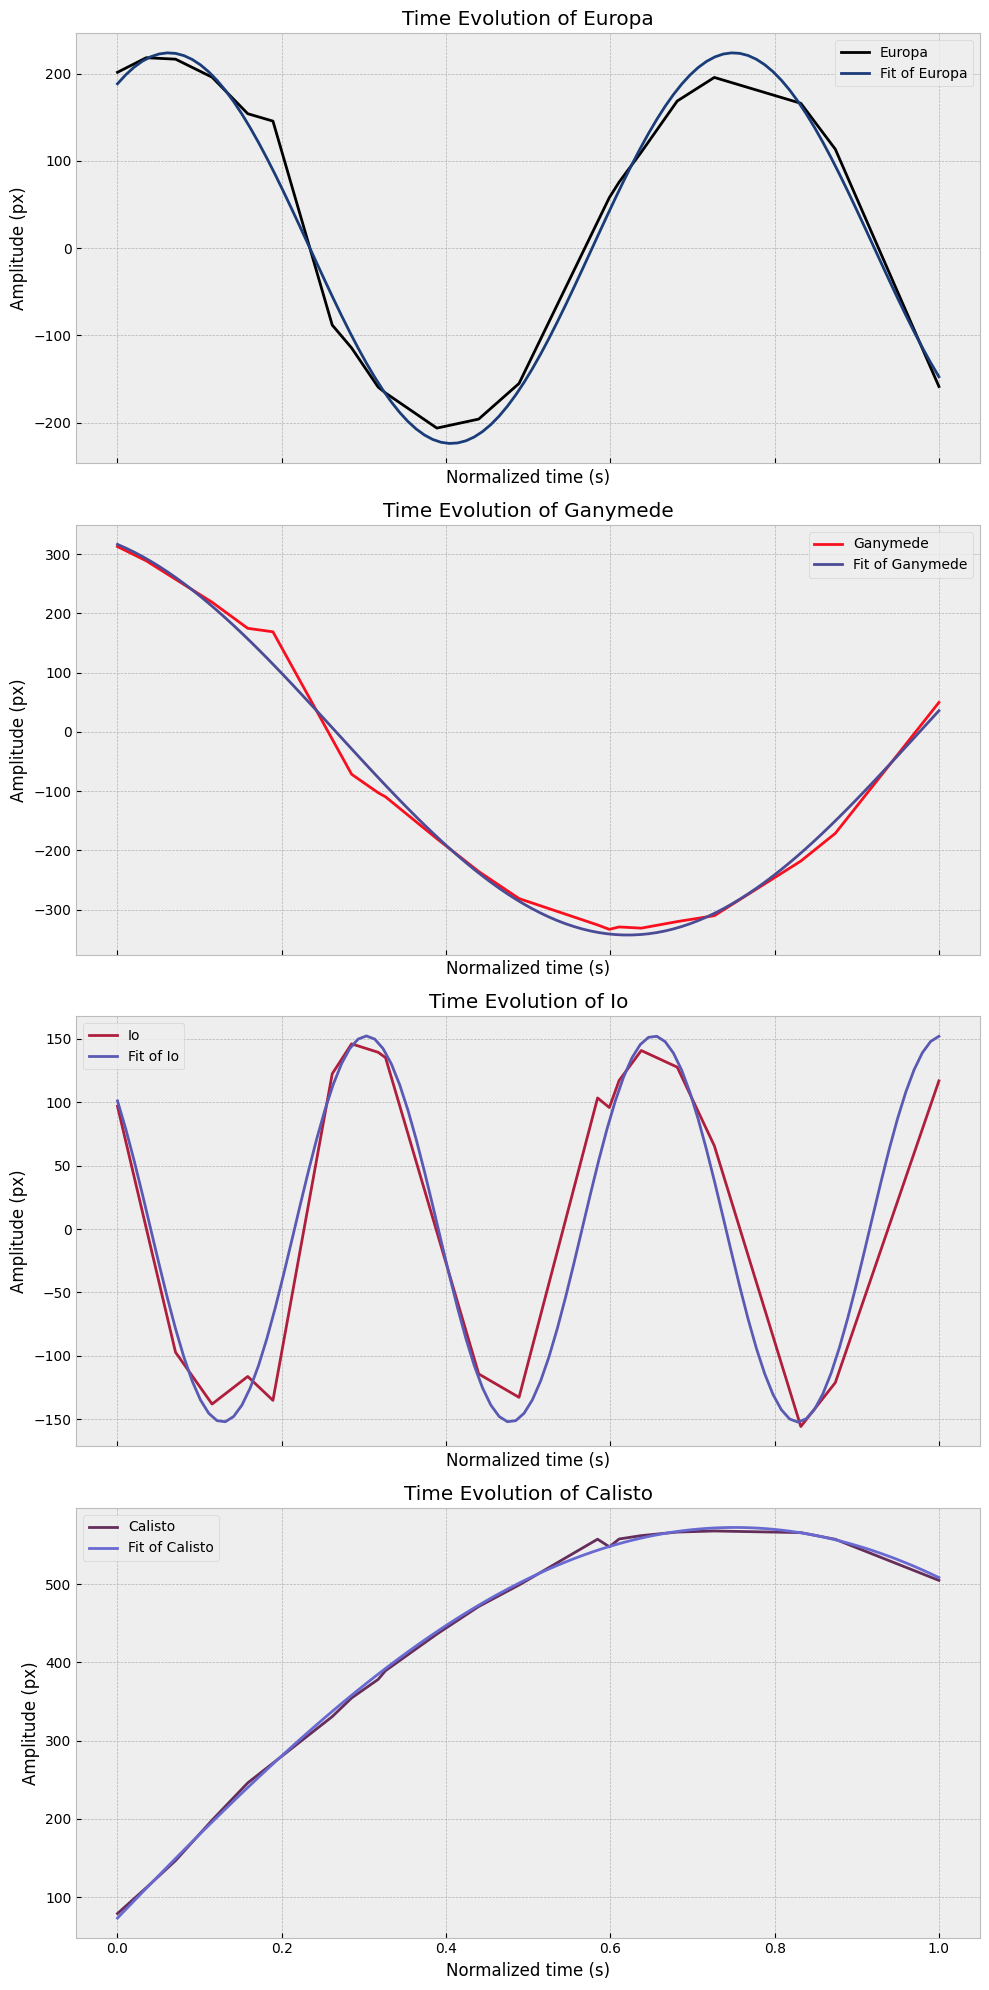

In [22]:
#Our approach is naive, we will need to be more sophisticated as curve_fit is not that well suited for our data
fig, axes = plt.subplots(4, 1, figsize=(10, 4 * 5), sharex=True)
colorMap = plt.get_cmap('gist_stern', 18)
for index, (sat, ax) in enumerate(zip(names, axes)):
    color,colorFit = colorMap(index), colorMap(index+4)
    ax.plot(np.array(dataDict[sat][0])/(np.max(dataDict[sat][0])-np.min(dataDict[sat][0])), dataDict[sat][1], label=sat,color=color)
    givenRange = np.linspace(0, 1, 100)
    fittedResult = fitFunc(givenRange, *params[index])
    ax.plot(givenRange, fittedResult, label="Fit of " + sat,color=colorFit)
    ax.set_title('Time Evolution of ' + sat)
    ax.set_xlabel('Normalized time (s)')
    ax.set_ylabel('Amplitude (px)')
    ax.legend()
plt.tight_layout()
plt.savefig('fitteddata.png')
plt.show()

In [23]:
#Now to turn this into into Km
convFactor = 24*3600
realAxis = [670_900,1_070_400, 421_700,1_882_700 ]
realPeriods = [3.551181*convFactor,7.15455296*convFactor,1.769137786*convFactor,16.6890184*convFactor]
realPeriods

[306822.0384, 618153.375744, 152853.50471039998, 1441931.1897599997]

In [45]:
#Lets see the fruits of our labor
for key,values in physicalValues.items():
    print(f'{key} has a major axis of : {values[0]}, a period of {values[1]}. The Kepler ratio is : {values[2]}')
#The periods are in absolute agreement with the observed ones

Europa has a major axis of : 223.68479232335056, a period of 296850.1630381561. The Kepler ratio is : 0.00012700908651773913
Ganymede has a major axis of : 342.6622541893995, a period of 613524.6498894084. The Kepler ratio is : 0.00010688943219579712
Io has a major axis of : 152.3502226791325, a period of 151245.0325806102. The Kepler ratio is : 0.00015458488969633297
Calisto has a major axis of : 572.507720492319, a period of 1413441.045294357. The Kepler ratio is : 9.392660945495656e-05


In [25]:
realPeriods

[306822.0384, 618153.375744, 152853.50471039998, 1441931.1897599997]

In [26]:
#Stellarium tells us that the apparent radius is 35.92 arc seconds and its distance from us
#5.489 AU, so we can do the simple calculation.
phi1 = math.tan(2*35.92*pxToRads) #We double as we are taking the tan(2theta)
#Finally, the radius of Jupyter is:
radiusJup = distanceJupyter*phi1/AUtoKm
print(radiusJup) #in Km. In great agreement with the real result of 69,911 Km

75445.72314925402


In [49]:
massArr = []
for index,name in enumerate(names):
    trueAxis = math.tan(2*physicalValues[name][0]*pxToRads)*distanceJupyter/AUtoKm
    trueRatio = (trueAxis*10**3)**3/physicalValues[name][1]**2
    #print(f'Our systemic factor being: {realAxis[index]/trueAxis}')
    trueAxisError = physicalValues[name][3]*(2*pxToRads/(1+(2*physicalValues[name][0]*pxToRads))**2)*distanceJupyter/AUtoKm
    calculatedMass = trueRatio*4*math.pi**2/G
    massError = calculatedMass*np.sqrt( (3*trueAxisError/trueAxis)**2  + (physicalValues[name][4]/physicalValues[name][1])**2)
    massArr.append([calculatedMass,massError])
    print(trueRatio,calculatedMass,massError)
    

1176873608471961.0 6.961195598460231e+26 8.614613692233133e+25
990444153908170.5 5.858467243273636e+26 3.865170033533149e+25
1432392358776731.2 8.47258644548168e+26 2.2071075459604927e+26
870331026663100.2 5.1479992994973285e+26 4.90611002500326e+24


In [56]:
mass = np.mean(np.array(massArr)[:,0]) #A few factors below the expected 1,898*10^27 Kg for the mass of jupyter

In [57]:
print(f'The calculated density is: {(mass*10**(3))/(4*math.pi*(radiusJup*10**(5))**3)}, with the real value being {1.33}')
#We are an order of magnitude off

The calculated density is: 0.12248750877555403, with the real value being 1.33
